# Compare to Scan Once
See how well we do given the same computing hours as the "screen once" option

In [1]:
%matplotlib inline 
from matplotlib import pyplot as plt
from datetime import datetime
from glob import glob
import pandas as pd
import json
import os

## Load in the Runs for Comparison
I want to compare runs from the active and single-pass strong-scaling runs. Get the path to the runs and some metadata

In [2]:
single_pass = [] 
for p in glob('../../atomization-energy-no-retrain/notebooks/scaling-runs/*-strong'):
    with open(os.path.join(p, 'run_params.json')) as fp:
        record = json.load(fp)
    record['path'] = p
    single_pass.append(record)
single_pass = pd.DataFrame(single_pass)

In [3]:
active = [] 
for p in glob('scaling-runs/*'):
    with open(os.path.join(p, 'run_params.json')) as fp:
        record = json.load(fp)
    record['path'] = p
    active.append(record)
active = pd.DataFrame(active)

## Load in Run Data
We want when the run started and the outcomes of each run

In [4]:
def get_qc_data(path):
    # Get the start time of the run
    with open(os.path.join(path, 'runtime.log')) as fp:
        start_time = datetime.strptime(fp.readline().split(" - ")[0], '%Y-%m-%d %H:%M:%S,%f').timestamp()
    
    # Load the data and compute walltime
    data_path = os.path.join(path, 'simulation_records.jsonld')
    if os.path.isfile(data_path):
        data = pd.read_json(data_path, lines=True)
        data['walltime'] = data['time_result_received'] - start_time
        return data
    return []
single_pass['qc_records'] = single_pass['path'].apply(get_qc_data)
active['qc_records'] = active['path'].apply(get_qc_data)

In [5]:
def get_geometry_optimizer(path):
    data_path = os.path.join(path, 'qcfractal_records.jsonld')
    if os.path.isfile(data_path):
        with open(data_path) as fp:
            record = json.loads(fp.readline())
        return record['provenance']['creator']
single_pass['optimizer'] = single_pass['path'].apply(get_geometry_optimizer)
active['optimizer'] = active['path'].apply(get_geometry_optimizer)

## Plot the records over time
We want to see the best found over time

Text(0, 0.5, '$E_{atom}$ (Ha)')

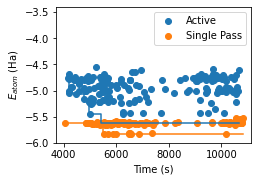

In [12]:
fig, ax = plt.subplots(figsize=(3.5, 2.5))

n_nodes = 256
for l, subset in zip(['Active', 'Single Pass'], [active, single_pass]):
    run = subset.query(f'nnodes=={n_nodes}').iloc[0]['qc_records'].sort_values('time_result_received').query('success')
    
    ax.scatter(run['walltime'], run['value'], label=l)
    ax.step(run['walltime'], run['value'].cummin())

ax.set_ylim(-6, -3.4)
ax.legend()
ax.set_xlabel('Time (s)')
ax.set_ylabel('$E_{atom}$ (Ha)')